In [257]:
from commonfunctions import *
from rle import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [258]:
from skimage.transform import resize as sk_resize
from skimage.filters import median, gaussian
from skimage.feature import canny
from skimage.filters import threshold_otsu
from collections import Counter
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line, rotate
from skimage import draw
from skimage.morphology import binary_opening, binary_closing, binary_dilation, binary_erosion, closing, opening, square
from skimage.transform import resize
from skimage.feature import match_template
from skimage.measure import label, regionprops

In [259]:
def gray_img(img):
    gray = rgb2gray(img)
    if len(img.shape) == 3:
        gray = gray*255
    return gray

In [260]:
def otsu(img):
    blur = gaussian(img)
    otsu_bin = 255*(blur > threshold_otsu(blur))
    return (otsu_bin/255).astype(np.int32)

In [261]:
def calculate_thickness_spacing(rle, most_common):
    bw_patterns = [most_common_bw_pattern(col, most_common) for col in rle]
    bw_patterns = [x for x in bw_patterns if x]  # Filter empty patterns

    flattened = []
    for col in bw_patterns:
        flattened += col

    pair, count = Counter(flattened).most_common()[0]

    line_thickness = min(pair)
    line_spacing = max(pair)

    return line_thickness, line_spacing


In [262]:
def whitene(rle, vals, max_height):
    rlv = []
    for length, value in zip(rle, vals):
        if value == 0 and length < max_height:
            value = 1
        rlv.append((length, value))

    n_rle, n_vals = [], []
    count = 0
    for length, value in rlv:
        if value == 1:
            count = count + length
        else:
            if count > 0:
                n_rle.append(count)
                n_vals.append(1)
            
            count = 0
            n_rle.append(length)
            n_vals.append(0)
    if count > 0:
        n_rle.append(count)
        n_vals.append(1)

    return n_rle, n_vals

def remove_staff_lines(rle, vals, thickness, shape):
    n_rle, n_vals = [], []
    for i in range(len(rle)):
        rl, val = whitene(rle[i], vals[i], 2 * thickness)
        n_rle.append(rl)
        n_vals.append(val)

    return hv_decode(n_rle, n_vals, shape)

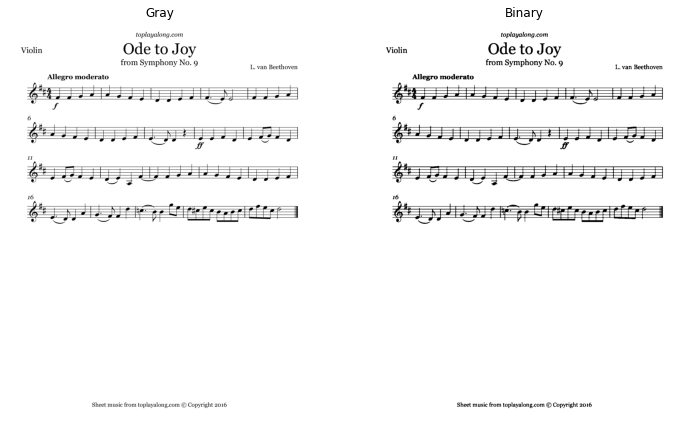

In [263]:
img = io.imread('dataset/ode.png')
original = img.copy()
gray = gray_img(img)
bin_img = otsu(gray)
show_images([gray, bin_img], ['Gray', 'Binary'])

In [264]:
rle, vals = hv_rle(bin_img)
most_common = get_most_common(rle)
thickness, spacing = calculate_thickness_spacing(rle, most_common)
print(most_common, thickness, spacing)

13 2 11


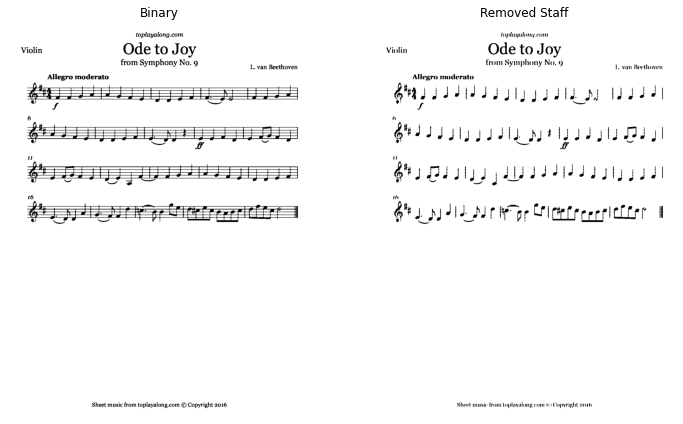

In [265]:
no_staff_img = remove_staff_lines(rle, vals, thickness, bin_img.shape)
show_images([bin_img, no_staff_img], ['Binary', 'Removed Staff'])

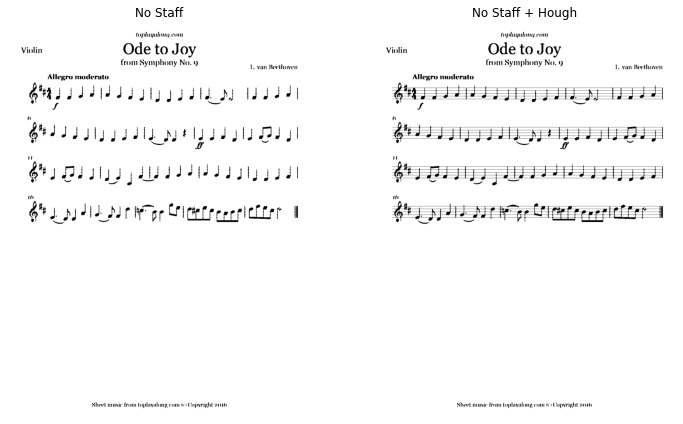

In [266]:
h_lines = probabilistic_hough_line(255-gray, threshold=gray.shape[1]//2)
lines = []
h_lines = sorted(h_lines, key=lambda l : l[0][1])

no_staff_lines = np.copy(no_staff_img)
for index, line in enumerate(h_lines):
    if index > 0 and (line[0][1] - lines[-1][0][1] < 0.9*spacing):
        pass
    else:
        p1, p2 = line
        x0, y0 = p1
        x1, y1 = p2
        lines.append(line)
        rr, cc = draw.line(x0, y0, x1, y0)
        # print(rr, cc)
        no_staff_lines[cc, rr] = 0

show_images([no_staff_img, no_staff_lines], ['No Staff', 'No Staff + Hough'])

In [267]:
end_of_staff = []
for index, line in enumerate(lines):
    if index > 0 and (line[0][1] - end_of_staff[-1][1] < 4*spacing):
        pass
    else:
        p1, p2 = line
        x0, y0 = p1
        x1, y1 = p2
        end_of_staff.append((x0, y0, x1, y1))

In [268]:
box_centers = []
spacing_between_staff_blocks = []
for i in range(len(end_of_staff)-1):
    spacing_between_staff_blocks.append(end_of_staff[i+1][1] - end_of_staff[i][1])
    if i % 2 == 0:
        offset = (end_of_staff[i+1][1] - end_of_staff[i][1])//2
        center = end_of_staff[i][1] + offset
        box_centers.append((center, offset))

max_staff_dist = np.max(spacing_between_staff_blocks)
max_margin = max_staff_dist // 2
margin = max_staff_dist // 10

In [299]:
end_points = []
regions_of_interest = []
regions_with_staff = []
img_with_bboxes = np.copy(gray)
for index, (center, offset) in enumerate(box_centers):
    y0 = int(center) - max_margin - offset + margin
    y1 = int(center) + max_margin + offset - margin
    end_points.append((y0, y1))

    rr, cc = draw.rectangle(start = (y0, 0), end = (y1, img_with_bboxes.shape[1]), shape=img_with_bboxes.shape)
    regions_with_staff.append(gray[y0:y1, 0:img_with_bboxes.shape[1]])
    staff_block = no_staff_img[y0:y1, 0:img_with_bboxes.shape[1]]
    regions_of_interest.append(opening(staff_block, np.ones((thickness, thickness))))
    img_with_bboxes[rr, cc] = 0

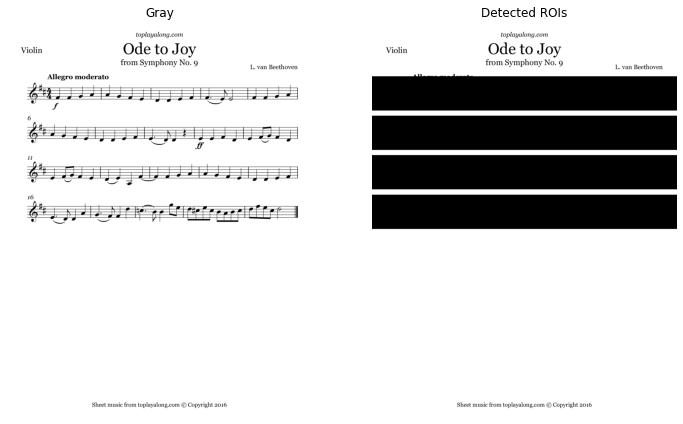

ROIs....


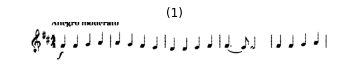

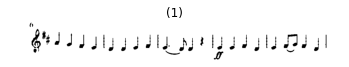

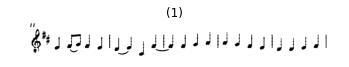

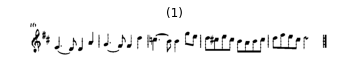

In [300]:
show_images([gray, img_with_bboxes], ['Gray', 'Detected ROIs'])
print('ROIs....')
if thickness % 2 == 0:
    thickness += 1
for staff_block in regions_of_interest:
    show_images([staff_block])

In [271]:
from skimage.color import label2rgb
import matplotlib.patches as mpatches

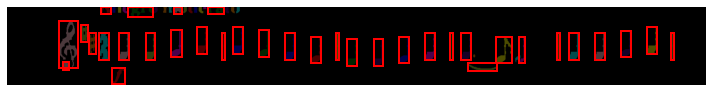

In [301]:
img = regions_of_interest[0]
img_with_staff = regions_with_staff[0]
primatives = []
thresh = threshold_otsu(img)
bw = closing(img <= thresh, square(3))
label_img = label(bw)
img_label_overlay = label2rgb(label_img, image=img, bg_label=0)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img_label_overlay)
for region in regionprops(label_img):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        primatives.append(img_with_staff[minr:maxr, minc:maxc])
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
ax.set_axis_off()
plt.tight_layout()
plt.show()

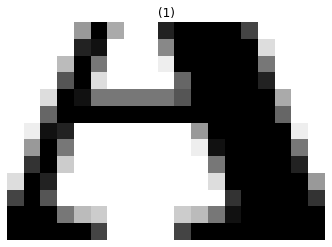

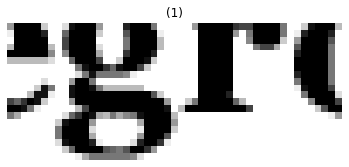

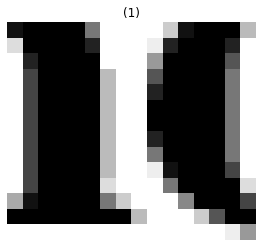

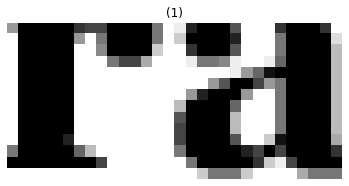

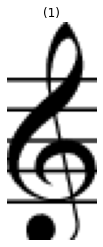

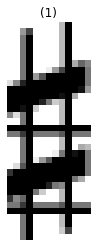

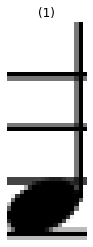

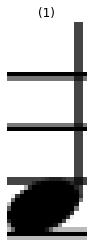

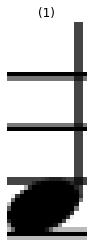

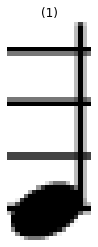

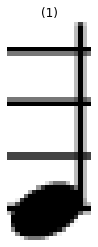

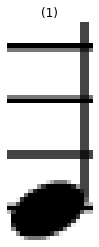

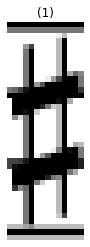

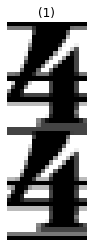

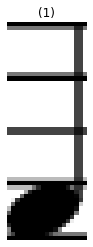

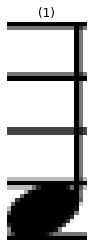

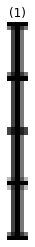

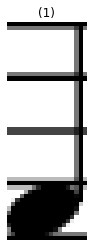

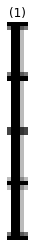

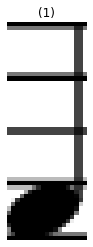

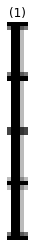

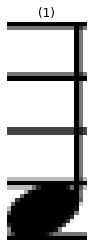

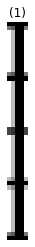

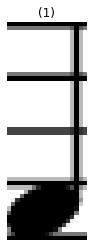

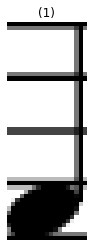

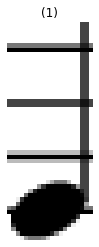

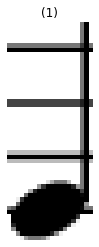

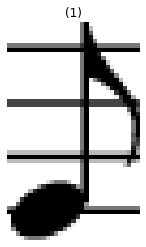

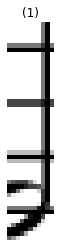

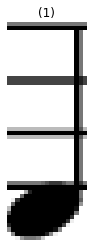

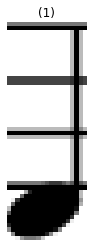

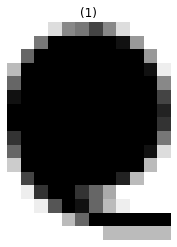

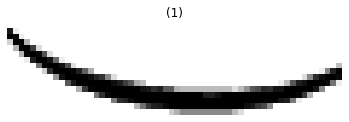

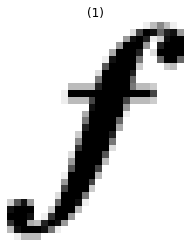

In [302]:
for prim in primatives:
    show_images([prim])

In [304]:
'''
Match Template technique has the disadvantage of that it's orientation and scale variant so we make pre-processing techniques to get all images in the same orientation and use multiscaling technique in matching and take the maximum correlation cooefecients
'''
def match(img, templates, lower_scale, upper_scale, threshold):
    scales = [i/100.0 for i in range(lower_scale, upper_scale+1, 3)]
    max_count = -1
    best_scale = 1
    best_locations = []
    for scale in scales:
        count = 0
        locations = []
        for template in templates:
            if scale*template.shape[0] > img.shape[0] or scale*template.shape[1] > img.shape[1]:
                continue

            template = resize(template, (int(scale*template.shape[0]), int(scale*template.shape[1])))
            template = gray_img(template)
            # template = otsu(template)
            result = (match_template(img, template))
            # print(result)
            result = np.where(result >= threshold)
            count += len(result[0])
            locations += [result]

        if count > max_count:
            max_count = count
            best_scale = scale
            best_locations = locations
    
    detected = []
    for i in range(len(templates)):
        scaled_height = best_scale*templates[i].shape[0]
        scaled_width = best_scale*templates[i].shape[1]
        locs = [(point[0], point[1], scaled_width, scaled_height) for point in zip(*best_locations[i][::-1])]
        detected.append(locs)
    
    return detected

In [275]:
def distance(box_a, box_b):
    return np.sqrt(((box_a[0]+box_a[2]/2)-(box_b[0]+box_b[2]/2))**2 + ((box_a[1]+box_a[3]/2)-(box_b[1]+box_b[3]/2))**2)

In [276]:
def calculate_overlap_area(box_a, box_b):
    x = max(0, min(box_a[0]+box_a[2], box_b[0]+box_b[2]) - max(box_a[0], box_b[0]))
    y = max(0, min(box_a[1]+box_a[3], box_b[1]+box_b[3]) - max(box_a[1], box_b[3]))
    area = x*y
    return area

In [277]:
def overlap(box_a, box_b, thresh):
    area_a = box_a[2]*box_a[3]
    area_b = box_b[2]*box_b[3]
    overlapped = False
    if ((calculate_overlap_area(box_a, box_b)/area_a) > thresh) or ((calculate_overlap_area(box_b, box_a)/area_b) > thresh): 
        overlapped = True
    return overlapped

In [278]:
'''
To determine if the template found or not we will combine all the detected boundary boxes from the match function. In another words, we need to try to get the best boundary box of the detected locations: https://www.sicara.ai/blog/object-detection-template-matching
'''
def get_best_bbox(q, thresh):
    best_bbox = []
    while len(q) > 0:
        box = q.pop(0)
        q.sort(key=lambda b: distance(b, box))
        overlapped = True
        while overlapped:
            overlapped = False
            i = 0
            for _ in range(len(q)):
                b = q[i]
                if overlap(box, b, thresh):
                    x = min(box[0], b[0])
                    y = min(box[1], b[1])
                    box = (x, y, max(b[0]+b[2], box[0]+box[2])-x, max(b[1]+b[3], box[1]+box[3])-y)
                    overlapped = True
                    b = q.pop(i)
                elif distance(box, b) > b[2]/2+box[2]/2:
                    break
                else:
                    i = i + 1
        best_bbox.append(box)
    
    return best_bbox

In [283]:
clef_lower, clef_upper, clef_thresh = 20, 100, 0.7

clef_imgs = {
    "treble": [io.imread('dataset/treble_1.jpg'), io.imread('dataset/treble_2.jpg')],
    "bass": [io.imread('dataset/bass_1.jpg')],
    "clef": [io.imread('clef8.jpg')]
}

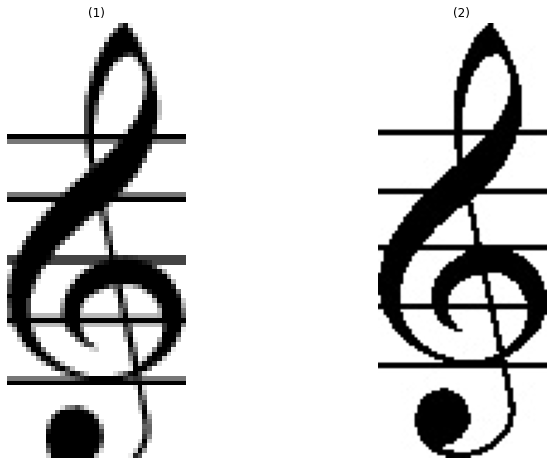

Trying....
[[(1, 1, 58.8, 151.9), (2, 1, 58.8, 151.9), (0, 2, 58.8, 151.9), (1, 2, 58.8, 151.9), (2, 2, 58.8, 151.9), (0, 3, 58.8, 151.9), (1, 3, 58.8, 151.9), (2, 3, 58.8, 151.9), (1, 4, 58.8, 151.9)]]
Finished Detection...
Finished Detection...
Not Found :(


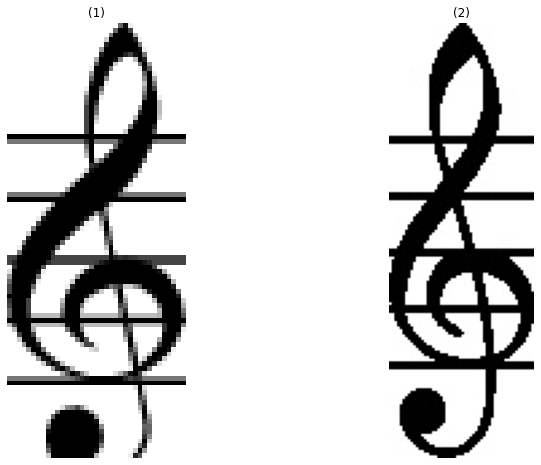

Trying....
[[(0, 1, 52.92, 158.76), (1, 1, 52.92, 158.76), (2, 1, 52.92, 158.76), (0, 2, 52.92, 158.76), (1, 2, 52.92, 158.76), (2, 2, 52.92, 158.76), (0, 3, 52.92, 158.76), (1, 3, 52.92, 158.76), (2, 3, 52.92, 158.76), (1, 4, 52.92, 158.76)]]
Finished Detection...
Finished Detection...
Not Found :(


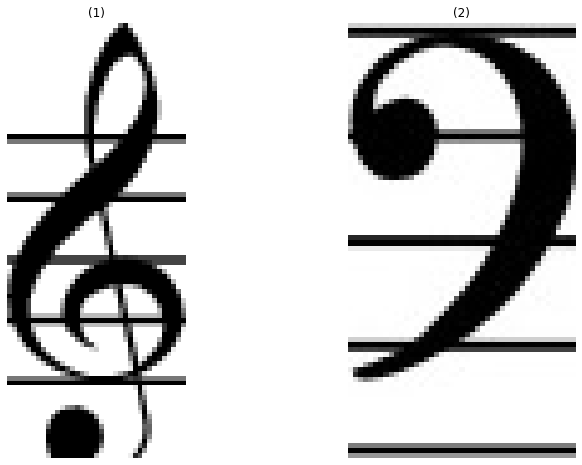

Trying....
[[(3, 1, 42.75, 81.7), (2, 2, 42.75, 81.7), (3, 2, 42.75, 81.7), (1, 3, 42.75, 81.7), (2, 3, 42.75, 81.7), (3, 3, 42.75, 81.7)]]
Finished Detection...
Finished Detection...
Not Found :(


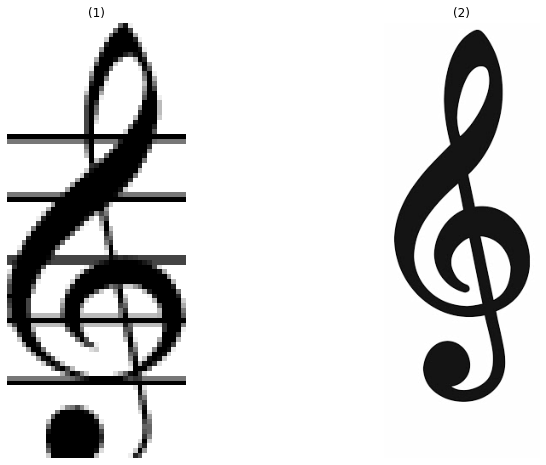

Trying....
[[(4, 4, 173.85, 486.4), (5, 4, 173.85, 486.4), (6, 4, 173.85, 486.4), (3, 5, 173.85, 486.4), (4, 5, 173.85, 486.4), (5, 5, 173.85, 486.4), (6, 5, 173.85, 486.4), (7, 5, 173.85, 486.4), (3, 6, 173.85, 486.4), (4, 6, 173.85, 486.4), (5, 6, 173.85, 486.4), (6, 6, 173.85, 486.4), (7, 6, 173.85, 486.4), (2, 7, 173.85, 486.4), (3, 7, 173.85, 486.4), (4, 7, 173.85, 486.4), (5, 7, 173.85, 486.4), (6, 7, 173.85, 486.4), (7, 7, 173.85, 486.4), (8, 7, 173.85, 486.4), (2, 8, 173.85, 486.4), (3, 8, 173.85, 486.4), (4, 8, 173.85, 486.4), (5, 8, 173.85, 486.4), (6, 8, 173.85, 486.4), (7, 8, 173.85, 486.4), (8, 8, 173.85, 486.4), (1, 9, 173.85, 486.4), (2, 9, 173.85, 486.4), (3, 9, 173.85, 486.4), (4, 9, 173.85, 486.4), (5, 9, 173.85, 486.4), (6, 9, 173.85, 486.4), (7, 9, 173.85, 486.4), (8, 9, 173.85, 486.4), (1, 10, 173.85, 486.4), (2, 10, 173.85, 486.4), (3, 10, 173.85, 486.4), (4, 10, 173.85, 486.4), (5, 10, 173.85, 486.4), (6, 10, 173.85, 486.4), (7, 10, 173.85, 486.4), (8, 10, 173.85

In [310]:
# img = regions_of_interest[1]
# for clef in clef_imgs:
#     detected_locations = match(img, clef_imgs[clef], clef_lower, clef_upper, clef_thresh)
#     best_bbox = get_best_bbox([j for i in detected_locations for j in i], 0.5)
#     if len(best_bbox) == 1:
#         print("Found :)")
#         # show_images([clef_img], ['Detected Clef'])
#     else:
#         print("Not Found :(")
# img = binary_erosion(img, np.ones((3, 3)))
for clef in clef_imgs:
    for clef_img in clef_imgs[clef]:
        # for primative in primatives:
        clef_img = gray_img(clef_img)
        prim = primatives[4]
        # if clef_img.shape < prim.shape:
        #     prim = resize(prim, clef_img.shape)
        # else:
        #     clef_img = resize(clef_img, prim.shape)
        # prim = binary_closing(prim, np.ones((3, 3)))
        show_images([prim, clef_img])
        print('Trying....')
        detected_locations = match(clef_img, [clef_img], clef_lower, clef_upper, clef_thresh)
        
        print(detected_locations)
        print('Finished Detection...')
        best_bbox = get_best_bbox([j for i in detected_locations for j in i], 0.5)
        print('Finished Detection...')


        if len(best_bbox) == 1:
            print("Found :)")
            show_images([clef_img], ['Detected Clef'])
        else:
            print("Not Found :(")